# 0. ATTACHING MAIN PACKAGES

This section loads the required libraries and sets up the plotting style for the analysis.

In [2]:
import os  # Interact with the operating system
import pandas as pd  # Data manipulation and analysis\import sys  # System-specific parameters and functions
import numpy as np  # Numerical computing library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
import math  # Mathematical functions
from IPython.display import display, HTML  # Display rich content in notebooks

sns.set_style("whitegrid")  # Apply a clean grid style to all seaborn plots
%matplotlib inline  # Ensure plots render inline in Jupyter notebooks

UsageError: unrecognized arguments: # Ensure plots render inline in Jupyter notebooks


# 1. READING THE FUNNEL DATA

Defines the path to the data directory and provides a function to load Excel files into DataFrames.

In [6]:
# Directory where data files are stored
data_path = r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\00 Data"

# Function to load each Excel file into its own DataFrame
def load_excel_dataframe(filename: str, sheet_name: str) -> pd.DataFrame:
    """
    Load a sheet from an Excel file into a pandas DataFrame.
    Prints the shape on success or an error message on failure.
    """
    file_path = os.path.join(data_path, filename)  # Construct the full file path
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)  # Read the specified sheet
        print(f"Loaded '{sheet_name}' from '{filename}' (shape: {df.shape})")  # Log success
        return df  # Return the loaded DataFrame
    except Exception as e:
        print(f"Error loading '{sheet_name}' from '{filename}': {e}")  # Log error
        return pd.DataFrame()  # Return an empty DataFrame on failure

# Load DataFrame for the funnel data
df1 = load_excel_dataframe("Funnel.xlsx", "funnel_data")

Loaded 'funnel_data' from 'Funnel.xlsx' (shape: (9373, 18))


Data preview

In [7]:
df1.shape

(9373, 18)

In [8]:
df1.dtypes

affinity_name                object
status_report                object
offer_number                  int64
policy_number               float64
zipcode_link                  int64
zip4                          int64
birth_date           datetime64[ns]
brand                        object
date_offer           datetime64[ns]
date_request         datetime64[ns]
policy_start_date    datetime64[ns]
premium                     float64
buildyear_car               float64
buildmonth_car               object
wa                           object
wa_bep_ca                    object
wa_ca                        object
updated_on           datetime64[ns]
dtype: object

# Descriptive statistics
Compute summary statistics by data type and format the results for display.

In [10]:
# 1) Identify columns by data type
num_cols = df1.select_dtypes(include="number").columns  # Numeric columns

dt_cols  = df1.select_dtypes(include="datetime64[ns]").columns  # Datetime columns
obj_cols = df1.columns.difference(num_cols.union(dt_cols))  # Other (object) columns

# 2) Numeric summary
stats_num = df1[num_cols].describe().T  # Transposed numeric descriptives

# 3) Datetime summary
stats_dt = pd.DataFrame(index=dt_cols)  # Initialize DataFrame for datetime stats
stats_dt["count"] = df1[dt_cols].count()  # Non-null counts
stats_dt["min"]   = df1[dt_cols].min()  # Earliest dates
stats_dt["25%"]   = df1[dt_cols].quantile(0.25)  # 25th percentile
stats_dt["50%"]   = df1[dt_cols].median()  # Median dates
stats_dt["75%"]   = df1[dt_cols].quantile(0.75)  # 75th percentile
stats_dt["max"]   = df1[dt_cols].max()  # Latest dates

# 4) Object summary
stats_obj = df1[obj_cols].describe().T  # Descriptive stats for object columns

# 5) Combine summaries
stats = pd.concat([stats_num, stats_dt, stats_obj], sort=False)  # Merge all stats
stats.insert(0, "dtype", [df1[col].dtype for col in stats.index])  # Add dtype column

# 6) Define formatters
fmt_int = "{:,}"  # Integer formatting with commas
fmt_2dp = "{:,.0f}"  # Two-decimal formatting without decimals

def fmt_general(x):
    """General formatter for dates, numbers, and missing values."""
    if pd.isna(x):
        return "—"  # Placeholder for missing
    if isinstance(x, pd.Timestamp):
        return x.strftime("%Y-%m-%d")  # Format datetime values
    try:
        return fmt_2dp.format(x)  # Format numeric values
    except Exception:
        return str(x)  # Fallback representation

# Map statistic columns to formatter functions
formats = {
    "mean": fmt_2dp,
    "std":  fmt_2dp,
    "count": fmt_int,
    "unique": fmt_int,
    "freq":   fmt_int,
    **{c: fmt_general for c in ["min","25%","50%","75%","max"] if c in stats.columns}
}

# 7) Style & display
styled = (
    stats.style
         .format(formats, na_rep="—")  # Apply custom formatting
         .background_gradient(
             subset=["count"], cmap="Greens", vmin=0, vmax=stats["count"].max()
         )  # Gradient on count
         .set_properties(subset=["dtype"], **{"text-align": "left"})  # Align dtype column
         .set_caption("Descriptive Statistics — df1")  # Add caption
         .set_table_styles([
             {"selector": "caption",
              "props": [
                  ("caption-side", "top"),
                  ("font-size", "16px"),
                  ("font-weight", "bold")
              ]},
             {"selector": "th, td",
              "props": [("border", "1px solid #ddd")]}
         ])
)
display(styled)  # Render styled DataFrame

,dtype,count,mean,std,min,25%,50%,75%,max,unique,top,freq
offer_number,int64,"9,373.0","5,392","2,420","1,000","3,301","5,566","7,487","9,443",—,—,—
policy_number,float64,"2,572.0","11,110",555,"10,000","10,644","11,236","11,580","11,947",—,—,—
zipcode_link,int64,"9,373.0","12,685","1,609","10,000","11,267","12,664","14,076","15,582",—,—,—
zip4,int64,"9,373.0","4,498","2,391","1,011","2,645","3,824","6,712","9,991",—,—,—
premium,float64,"8,994.0",559,381,0,326,485,698,"3,781",—,—,—
buildyear_car,float64,"9,370.0","2,009",6,"1,979","2,004","2,009","2,014","2,020",—,—,—
birth_date,datetime64[ns],"9,230",—,—,1919-01-01,1961-08-01,1976-02-01,1990-07-01,2002-01-01,—,—,—
date_offer,datetime64[ns],"9,373",—,—,2018-10-11,2019-06-24,2019-10-21,2019-12-19,2020-03-08,—,—,—
date_request,datetime64[ns],"2,572",—,—,2018-10-11,2019-06-13,2019-10-21,2019-12-19,2020-03-08,—,—,—
policy_start_date,datetime64[ns],"2,676",—,—,1920-06-03,2019-06-21,2019-11-01,2020-01-01,2021-02-04,—,—,—


# Missing Values Summary
Compute the counts of missing values per column and style the results for readability.

In [12]:
# Build a one-column DataFrame of missing value counts
missing_tbl = (
    df1.isna().sum()               # Count missing values per column
       .to_frame('Missing values') # Convert to DataFrame with named column
       .sort_values('Missing values', ascending=False)  # Sort descending by missing count
)

# Style the missing values table for emphasis and readability
styled1 = (
    missing_tbl.style
        .format('{:,}')                          # Thousand separators for counts
        .background_gradient(cmap="Reds")       # Red heatmap to highlight high missing counts
        .set_caption('Missing-Value Summary for df1')  # Add caption
        .set_table_styles(
            [{'selector': 'caption',
              'props': [
                  ('font-size', '16px'),
                  ('font-weight', 'bold'),
                  ('text-align', 'left')
              ]}]
        )
)

display(styled1)  # Render styled DataFrame (as originally coded)

,Missing values
date_request,"6,801"
policy_number,"6,801"
policy_start_date,"6,697"
wa_bep_ca,"6,312"
wa,"5,792"
wa_ca,"5,282"
premium,379
birth_date,143
brand,3
buildyear_car,3


## Histograms for Selected Numeric Columns

Generate histograms with KDE overlays for specified numeric columns to visualize their distributions.

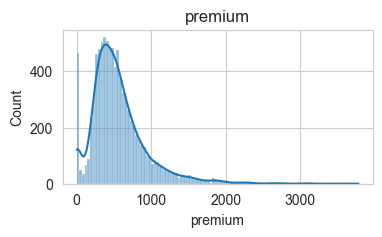

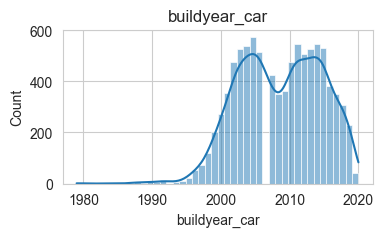

In [13]:
# Select numeric columns from specified subset
num_cols = df1[["premium","buildyear_car"]].select_dtypes(include=np.number).columns  # Choose numeric subset

for col in num_cols:
    plt.figure(figsize=(4,2))   # Set figure dimensions
    sns.histplot(df1[col].dropna(), kde=True)  # Plot histogram with kernel density estimate
    plt.title(col)            # Title plot with column name
    plt.show()                # Render the figure

## Density Plot by Categorical Variable

Plot kernel density estimates of the 'premium' variable for two affinity groups.

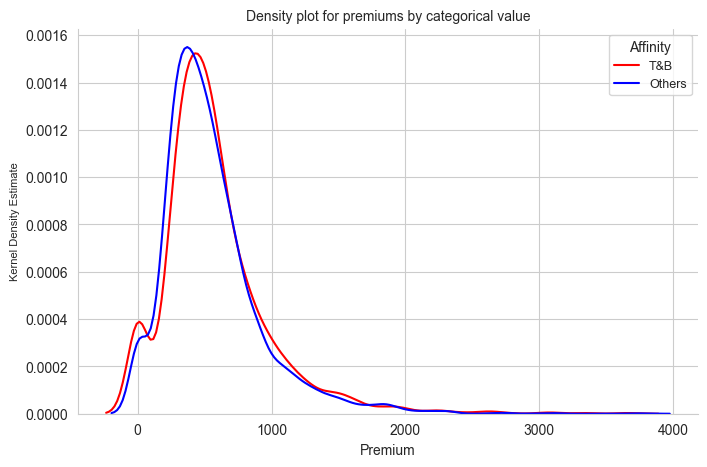

In [14]:
# Initialize figure and axes for density plots
fig, ax = plt.subplots(figsize=(8,5))

# KDE for T&B group
sns.kdeplot(
    df1.loc[df1['affinity_name']=='T&B','premium'],  # Filter data for T&B
    fill=False, color='red',                         # Red line without fill
    label='T&B'                                      # Legend label
)

# KDE for all other groups
sns.kdeplot(
    df1.loc[df1['affinity_name']!='T&B','premium'],  # Filter data for others
    fill=False, color='blue',                        # Blue line without fill
    label='Others'                                   # Legend label
)

# Aesthetic adjustments
sns.despine()  # Remove top and right spines
ax.set_title("Density plot for premiums by categorical value", fontsize=10)  # Set plot title
ax.set_xlabel("Premium")  # X-axis label
ax.set_ylabel("Kernel Density Estimate", fontsize=8)  # Y-axis label

# Display legend with title and formatting
ax.legend(title="Affinity", loc='best', fontsize=9, title_fontsize=10)

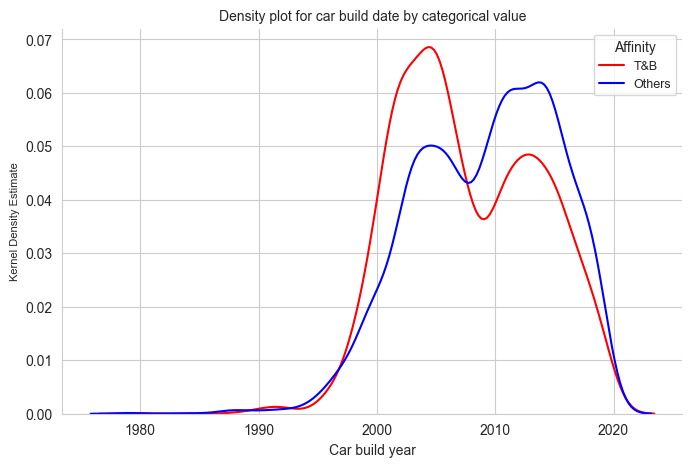

In [15]:
# Initialize figure and axes for density plots
fig, ax = plt.subplots(figsize=(8,5))

# KDE for T&B group
sns.kdeplot(
    df1.loc[df1['affinity_name']=='T&B','buildyear_car'],  # Filter data for T&B group
    fill=False, color='red',                                # Red line without fill
    label='T&B'                                             # Legend label
)

# KDE for all other groups
sns.kdeplot(
    df1.loc[df1['affinity_name']!='T&B','buildyear_car'],  # Filter data for others
    fill=False, color='blue',                              # Blue line without fill
    label='Others'                                          # Legend label
)

# Aesthetic adjustments
sns.despine()  # Remove top and right spines
ax.set_title("Density plot for car build date by categorical value", fontsize=10)  # Set plot title
ax.set_xlabel("Car build year")  # X-axis label
ax.set_ylabel("Kernel Density Estimate", fontsize=8)  # Y-axis label

# Display legend with title and formatting
ax.legend(title="Affinity", loc='best', fontsize=9, title_fontsize=10)

## 2. READING THE POLICY DATA

In [17]:
# Load DataFrames
df2 = load_excel_dataframe("Policy.xlsx", "policies_data")

Loaded 'policies_data' from 'Policy.xlsx' (shape: (13365, 26))


In [18]:
df2.shape

(13365, 26)

## Descriptive Statistics for df2

Compute and display summary statistics for DataFrame df2, grouped by data types (numeric, datetime, object), with formatted styling.

In [19]:
# 1) Split columns by data type
num_cols = df2.select_dtypes(include="number").columns  # Numeric columns

dt_cols  = df2.select_dtypes(include="datetime64[ns]").columns  # Datetime columns
obj_cols = df2.columns.difference(num_cols.union(dt_cols))     # Other (object) columns

# 2) Numeric summary
stats_num = df2[num_cols].describe().T  # Transposed numeric descriptives

# 3) Datetime summary
stats_dt = pd.DataFrame(index=dt_cols)            # Initialize DataFrame for datetime stats
stats_dt["count"] = df2[dt_cols].count()        # Non-null counts
stats_dt["min"]   = df2[dt_cols].min()          # Earliest dates
stats_dt["25%"]   = df2[dt_cols].quantile(0.25) # 25th percentile
stats_dt["50%"]   = df2[dt_cols].median()       # Median dates
stats_dt["75%"]   = df2[dt_cols].quantile(0.75) # 75th percentile
stats_dt["max"]   = df2[dt_cols].max()          # Latest dates

# 4) Object summary
stats_obj = df2[obj_cols].describe().T  # Descriptive stats for object columns

# 5) Combine all summaries
stats = pd.concat([stats_num, stats_dt, stats_obj], sort=False)  # Merge summaries
stats.insert(0, "dtype", [df2[col].dtype for col in stats.index])  # Add dtype column

# 6) Define formatter functions
fmt_int  = "{:,}"    # Integer formatting with commas
fmt_2dp  = "{:,.0f}" # Two-decimal formatting without decimals

def fmt_general(x):
    """Format dates, numbers, and missing values for display."""
    if pd.isna(x):
        return "—"                     # Placeholder for missing
    if isinstance(x, pd.Timestamp):
        return x.strftime("%Y-%m-%d")  # Format datetime
    try:
        return fmt_2dp.format(x)         # Format numeric
    except Exception:
        return str(x)                    # Fallback

formats = {
    "mean": fmt_2dp,
    "std":  fmt_2dp,
    "count": fmt_int,
    "unique": fmt_int,
    "freq":   fmt_int,
    **{c: fmt_general for c in ["min","25%","50%","75%","max"] if c in stats.columns}
}

# 7) Style and display the table
styled_df2 = (
    stats.style
         .format(formats, na_rep="—")                      # Apply formatters
         .background_gradient(subset=["count"],            # Gradient on count
                              cmap="Greens",
                              vmin=0,
                              vmax=stats["count"].max())
         .set_properties(subset=["dtype"], **{"text-align": "left"})  # Align dtype
         .set_caption("Descriptive Statistics — df2")        # Add caption
         .set_table_styles([
             {"selector": "caption",
              "props": [("caption-side", "top"),
                        ("font-size", "16px"),
                        ("font-weight", "bold")]},
             {"selector": "th, td",
              "props": [("border", "1px solid #ddd")]}  
         ])
)
display(styled_df2)  # Render styled DataFrame for df2

,dtype,count,mean,std,min,25%,50%,75%,max,unique,top,freq
policy_number,int64,"13,365.0","18,364","3,892","10,295","15,041","18,382","21,723","25,064",—,—,—
premium_wa,float64,"13,054.0",844,271,27,672,821,997,"3,343",—,—,—
premium_other,float64,"11,899.0",592,528,0,140,493,918,"7,646",—,—,—
zipcode_link,int64,"13,365.0","19,767","3,553","10,073","17,161","19,834","22,749","25,609",—,—,—
zip4,int64,"13,365.0","4,636","2,403","1,011","2,729","3,861","6,846","9,994",—,—,—
bonus_malus_percent,float64,"12,998.0",69,11,10,65,75,75,80,—,—,—
premium_other_incl_discount,float64,"8,820.0",719,473,27,367,624,977,"7,426",—,—,—
worth_car,float64,"12,259.0","21,037","11,582","1,750","12,785","18,010","26,314","162,546",—,—,—
weight_car,float64,"12,766.0","1,090",252,0,900,"1,050","1,255","3,300",—,—,—
power_car,float64,"12,248.0",72,26,21,51,66,85,307,—,—,—


## Missing Values Summary for df2

Compute and display missing value counts per column with styled formatting.

In [20]:
# Build a one-column DataFrame of missing value counts
missing_tbl = (
    df2.isna().sum()               # Count missing values per column
       .to_frame('Missing values') # Convert to DataFrame with named column
       .sort_values('Missing values', ascending=False)  # Sort descending by missing count
)

# Style the missing values table for emphasis
styled_missing = (
    missing_tbl.style
        .format('{:,}')                          # Thousand separators for counts
        .background_gradient(cmap="Reds")       # Red heatmap to highlight high missing counts
        .set_caption('Missing-Value Summary for df2')  # Add caption
        .set_table_styles(
            [{'selector': 'caption',
              'props': [
                  ('font-size', '16px'),
                  ('font-weight', 'bold'),
                  ('text-align', 'left')
              ]}]
        )
)

display(styled_missing)  # Render styled missing-values table

,Missing values
other_cover,"4,546"
premium_other_incl_discount,"4,545"
drive,"1,494"
turbo,"1,491"
premium_other,"1,466"
transmission,"1,462"
power_car,"1,117"
worth_car,"1,106"
chassis,914
weight_car,599


## Global Plot Settings & Histograms for df2

Configure global font sizes for matplotlib and generate histograms with KDE overlays for selected numeric columns in df2.

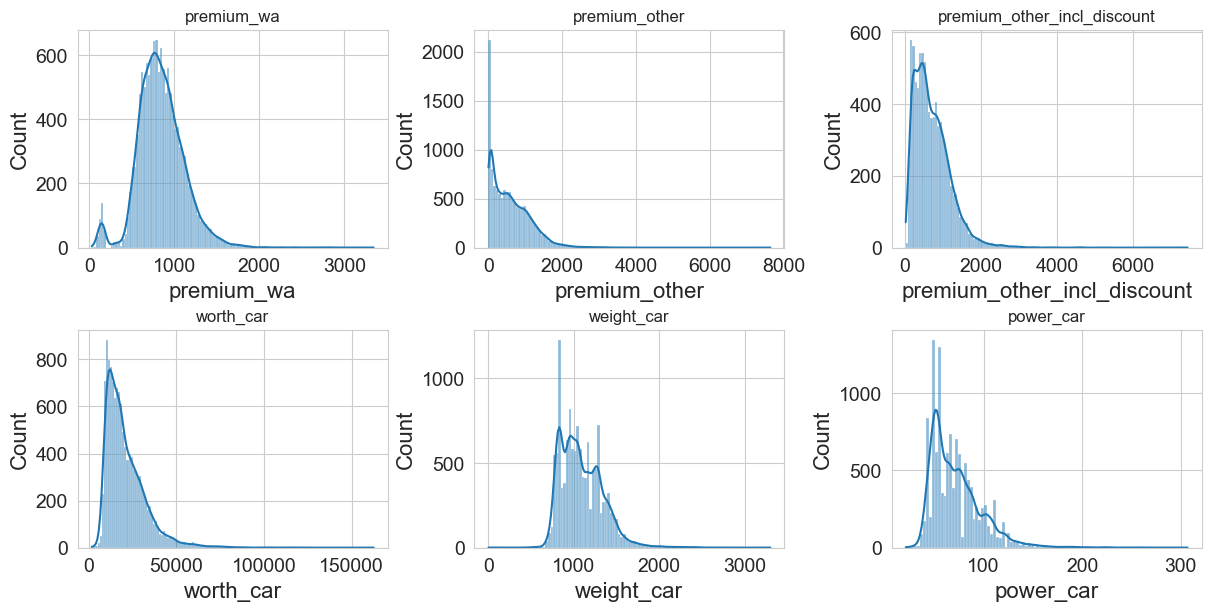

In [21]:
# 1) Set global font sizes for consistent styling
plt.rcParams['axes.titlesize'] = 20      # Title size
plt.rcParams['axes.labelsize'] = 16      # X/Y label size
plt.rcParams['xtick.labelsize'] = 14     # X-tick label size
plt.rcParams['ytick.labelsize'] = 14     # Y-tick label size

# 2) Select numeric columns to plot
num_cols = df2[[
    "premium_wa",
    "premium_other",
    "premium_other_incl_discount",
    "worth_car",
    "weight_car",
    "power_car"
]].select_dtypes(include=np.number).columns  # Filter numeric subset

# 3) Determine grid layout for subplots
n_cols   = 3                                # Number of columns in the grid
n_plots  = len(num_cols)                    # Total number of plots
n_rows   = math.ceil(n_plots / n_cols)      # Calculate required rows

# 4) Create subplots with constrained layout to avoid overlap
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 4, n_rows * 3),       # Figure size per subplot
    constrained_layout=True                 # Prevent label/title overlap
)

# Flatten axes for easy iteration
axes = axes.flat

# 5) Plot histograms with KDE for each selected column
for ax, col in zip(axes, num_cols):
    sns.histplot(
        df2[col].dropna(),  # Drop missing values
        kde=True,           # Show kernel density estimate
        ax=ax               # Draw on current axis
    )
    ax.set_title(col, fontsize=12)  # Label each subplot

# 6) Hide any unused subplots in the grid
for ax in axes[n_plots:]:
    ax.set_visible(False)

# 7) Display all figures
plt.show()

## DENSITY PLOT FOR PREMIUM BY CATEGORICAL VARIABLE

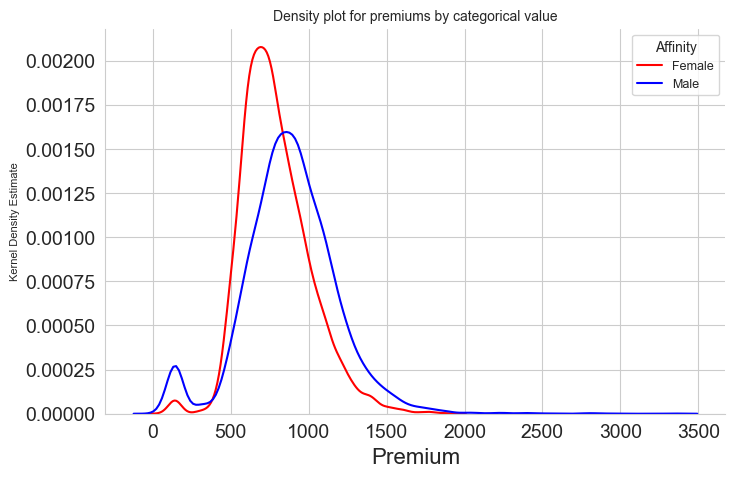

In [22]:
fig, ax = plt.subplots(figsize=(8,5))

# Give each line a label=… argument
sns.kdeplot(
    df2.loc[df2['gender']=='F','premium_wa'],
    fill=False, color='red',
    label='Female'
)
sns.kdeplot(
    df2.loc[df2['gender']=='M','premium_wa'],
    fill=False, color='blue',
    label='Male'
)

# Decoration
sns.despine()
ax.set_title("Density plot for premiums by categorical value", fontsize=10)
ax.set_xlabel("Premium")
ax.set_ylabel("Kernel Density Estimate", fontsize=8)

# Show legend with an optional title
ax.legend(title="Affinity", loc='best', fontsize=9, title_fontsize=10)

# DENSITY PLOT FOR OTHER PREMIUM BY CATEGORICAL VARIABLE

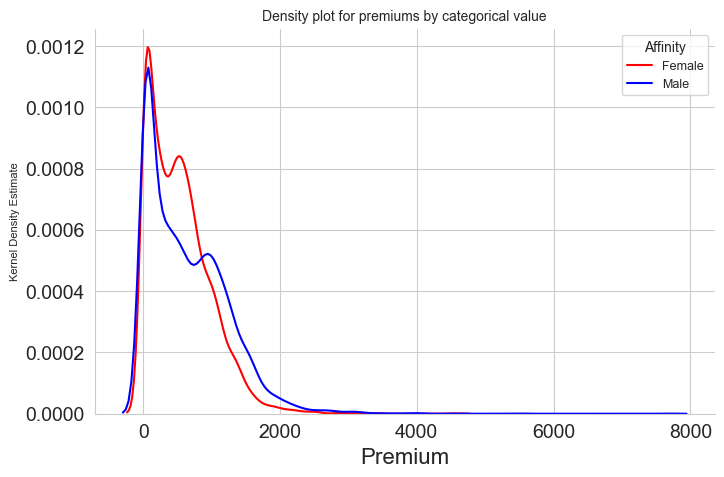

In [23]:
fig, ax = plt.subplots(figsize=(8,5))

# Give each line a label=… argument
sns.kdeplot(
    df2.loc[df2['gender']=='F','premium_other'],
    fill=False, color='red',
    label='Female'
)
sns.kdeplot(
    df2.loc[df2['gender']=='M','premium_other'],
    fill=False, color='blue',
    label='Male'
)

# Decoration
sns.despine()
ax.set_title("Density plot for premiums by categorical value", fontsize=10)
ax.set_xlabel("Premium")
ax.set_ylabel("Kernel Density Estimate", fontsize=8)

# Show legend with an optional title
ax.legend(title="Affinity", loc='best', fontsize=9, title_fontsize=10)

# DENSITY PLOT FOR PREMIUM INCL DISCOUNT BY CATEGORICAL VARIABLE

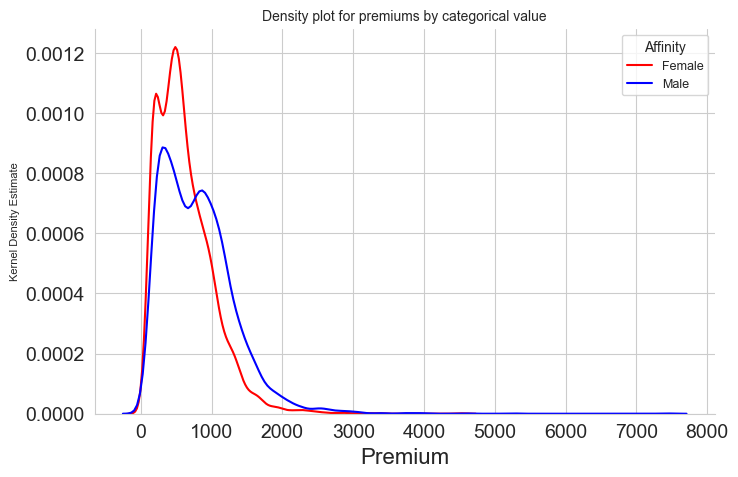

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

# Give each line a label=… argument
sns.kdeplot(
    df2.loc[df2['gender']=='F','premium_other_incl_discount'],
    fill=False, color='red',
    label='Female'
)
sns.kdeplot(
    df2.loc[df2['gender']=='M','premium_other_incl_discount'],
    fill=False, color='blue',
    label='Male'
)

# Decoration
sns.despine()
ax.set_title("Density plot for premiums by categorical value", fontsize=10)
ax.set_xlabel("Premium")
ax.set_ylabel("Kernel Density Estimate", fontsize=8)

# Show legend with an optional title
ax.legend(title="Affinity", loc='best', fontsize=9, title_fontsize=10)

# 3 READING THE REGIONAL DATA

In [25]:
# Load DataFrames
df3 = load_excel_dataframe("Regional.xlsx", "regional_data")

Loaded 'regional_data' from 'Regional.xlsx' (shape: (15539, 34))


In [26]:
df3.shape

(15539, 34)

## Descriptive Statistics for df3

Compute and display summary statistics for DataFrame df3, grouped by data types (numeric, datetime, object), with formatted styling.

In [28]:
# 1) Split columns by data type
num_cols = df3.select_dtypes(include="number").columns  # Numeric columns

dt_cols  = df3.select_dtypes(include="datetime64[ns]").columns  # Datetime columns
obj_cols = df3.columns.difference(num_cols.union(dt_cols))     # Other (object) columns

# 2) Numeric summary
stats_num = df3[num_cols].describe().T  # Transposed numeric descriptives

# 3) Datetime summary
stats_dt = pd.DataFrame(index=dt_cols)            # Initialize DataFrame for datetime stats
stats_dt["count"] = df3[dt_cols].count()        # Non-null counts
stats_dt["min"]   = df3[dt_cols].min()          # Earliest dates
stats_dt["25%"]   = df3[dt_cols].quantile(0.25) # 25th percentile
stats_dt["50%"]   = df3[dt_cols].median()       # Median dates
stats_dt["75%"]   = df3[dt_cols].quantile(0.75) # 75th percentile
stats_dt["max"]   = df3[dt_cols].max()          # Latest dates

# 4) Object summary
stats_obj = df3[obj_cols].describe().T  # Descriptive stats for object columns

# 5) Combine all summaries
stats = pd.concat([stats_num, stats_dt, stats_obj], sort=False)  # Merge summaries
stats.insert(0, "dtype", [df3[col].dtype for col in stats.index])  # Add dtype column

# 6) Define formatter functions
fmt_int = "{:,}"    # Integer formatting with commas
fmt_2dp = "{:,.0f}" # Two-decimal formatting without decimals

def fmt_general(x):
    """Format dates, numbers, and missing values for display."""
    if pd.isna(x):
        return "—"                     # Placeholder for missing
    if isinstance(x, pd.Timestamp):
        return x.strftime("%Y-%m-%d")  # Format datetime
    try:
        return fmt_2dp.format(x)         # Format numeric
    except Exception:
        return str(x)                    # Fallback

formats = {
    "mean": fmt_2dp,
    "std":  fmt_2dp,
    "count": fmt_int,
    "unique": fmt_int,
    "freq":   fmt_int,
    **{c: fmt_general for c in ["min","25%","50%","75%","max"] if c in stats.columns}
}

# 7) Style and display the table
styled = (
    stats.style
         .format(formats, na_rep="—")                      # Apply formatters
         .background_gradient(subset=["count"],            # Gradient on count
                              cmap="Greens",
                              vmin=0,
                              vmax=stats["count"].max())
         .set_properties(subset=["dtype"], **{"text-align": "left"})  # Align dtype
         .set_caption("Descriptive Statistics — df3")        # Add caption
         .set_table_styles([
             {"selector": "caption",
              "props": [("caption-side", "top"),
                        ("font-size", "16px"),
                        ("font-weight", "bold")]},
             {"selector": "th, td",
              "props": [("border", "1px solid #ddd")]}  
         ])
)
display(styled)  # Render styled DataFrame for df3

,dtype,count,mean,std,min,25%,50%,75%,max,unique,top,freq
zipcode_link,int64,"15,539.0","17,817","4,503","10,000","13,920","17,822","21,714","25,609",—,—,—
zip4,int64,"15,539.0","4,621","2,427","1,011","2,685","3,891","6,833","9,994",—,—,—
URB,int64,"15,539.0",4,2,1,2,4,5,7,—,—,—
INCOME,float64,"14,659.0",3,1,1,2,3,4,6,—,—,—
SOCCL_A,float64,"15,471.0",3,1,1,1,2,4,5,—,—,—
SOCCL_B1,float64,"15,471.0",3,1,1,2,3,3,5,—,—,—
SOCCL_B2,float64,"15,471.0",2,1,1,2,2,3,5,—,—,—
SOCCL_C,float64,"15,471.0",2,1,1,1,1,2,5,—,—,—
SOCCL_D,float64,"15,471.0",1,1,1,1,1,2,5,—,—,—
EDU_HIGH,float64,"15,471.0",3,1,1,2,2,4,5,—,—,—
